In [2]:
import pandas

In [3]:
sns.set_style('whitegrid')

In [4]:
def get_condition(row):
    
    even = not (row.subject_id % 2)
    
    if row.subject_id == 0:
        even = False
    
    if np.isnan(row['syncvalue[SubTrial]']):
        return np.nan
    
#     print row
    
    if even:
        return {11:'cs-', 12:'cs+', 14:'shock', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    else:
        return {11:'cs+', 12:'cs-', 13:'shock', np.nan:np.nan}[row['syncvalue[SubTrial]']]
    

In [5]:
df = pandas.read_excel('/home/gdholla1/data/daphne/behavior/Task1_All Participants.xlsx')
df.ix[df.Subject == 'P05', 'subject'] = 0

df['onset'] = df['face3sec.OnsetTime'] - df['Waitforscanner1c.RTTime']
df['onset'] /= 1000

# df['condition'] = df['syncvalue[SubTrial]']

# df['condition'] = df['condition'].map({11:'cs+', 12:'cs-', 13:'shock'})

df.ix[df.Subject == 'P05', 'Subject'] = 0

df['subject_id'] = df.Subject.astype(int)

df['condition'] = df.apply(get_condition, 1)

In [6]:
df.to_pickle('/home/gdholla1/data/daphne/behavior/all_data.pandas')

In [7]:
import pyfir

In [8]:
def get_signal(subject_id, mask, mask_type='disjunct', interpolation='nearestneighbour', phys_filtered=False):
    
    if mask == 'LC_both':
        signal1 = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_LC_L/_interp_trilinear/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id))        
        signal2 = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_LC_R/_interp_trilinear/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id))        
        
        signal = signal1 + signal2
        
        
    else:    
        signal = np.loadtxt('/home/gdholla1/data/daphne/registration_max/extracted_signal_weighted/_subject_id_S%02d/_mask_%2s/_interp_trilinear/_extract_weighted_phys0/run1_maths_maths_maths_dtype_mcf_mask_gms_tempfilt_regfilt_maths_weighted.txt' % (subject_id, mask))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

In [9]:
for row in df.ix[:]:
    row

In [12]:
df = pandas.read_pickle('/home/gdholla1/data/daphne/behavior/all_data.pandas')

df = df[df.Subject == subject_id]
df = df[~df.condition.isnull()]  

tmp = df.ix[df.condition == 'shock'].copy()
tmp['onset'] += 3
df.ix[df.condition == 'shock', 'condition'] = 'cs+'

df2 = pandas.concat((df, tmp), ignore_index=True)

NameError: name 'subject_id' is not defined

In [91]:
def get_onsets(subject_id, kind='simple'):
    
    df = pandas.read_pickle('/home/gdholla1/data/daphne/behavior/all_data.pandas')
    
    df = df[df.Subject == subject_id]
    df = df[~df.condition.isnull()]    
    
    if kind == 'simple':    
        onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
                  'cs-':df[df.condition == 'cs-'].onset.tolist(),
                  'shock':df[df.condition == 'shock'].onset.tolist()}
        
 
    if kind == 'single_trial':
        
        
        tmp = df.ix[df.condition == 'shock'].copy()
        tmp['onset'] += 3
        
        df.ix[df.condition == 'shock', 'condition'] = 'cs+'
    
        df = pandas.concat((df, tmp), ignore_index=True)
        
        df['single_trial_condition'] = df.groupby('condition').apply(lambda d: pandas.DataFrame(['%s.%d' % (row.condition, i+1) for i, (_, row) in enumerate(d.iterrows())], index=d.index))
        
        onsets = zip(df.single_trial_condition, df.onset)

        onsets = dict([(key, [value]) for key, value in onsets])
        
    
    if kind == 'deconvolve_shock_cs+':
        
        tmp = df.ix[df.condition == 'shock'].copy()
        tmp['onset'] += 3
        
        df.ix[df.condition == 'shock', 'condition'] = 'cs+'
    
        df = pandas.concat((df, tmp), ignore_index=True)
        
        onsets = {'cs+':df[df.condition == 'cs+'].onset.tolist(),
                  'cs-':df[df.condition == 'cs-'].onset.tolist(),
                  'shock':df[df.condition == 'shock'].onset.tolist()}
    
    return onsets
    
    
    

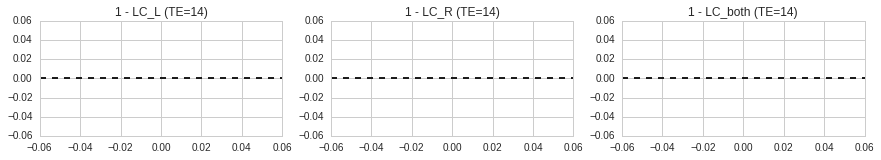

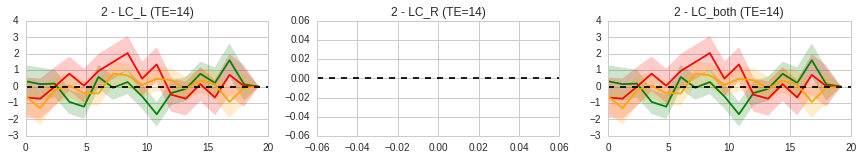

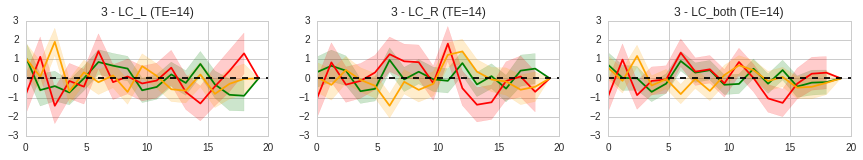

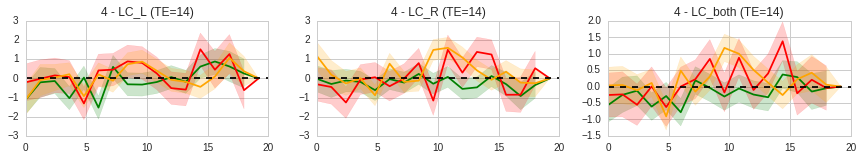

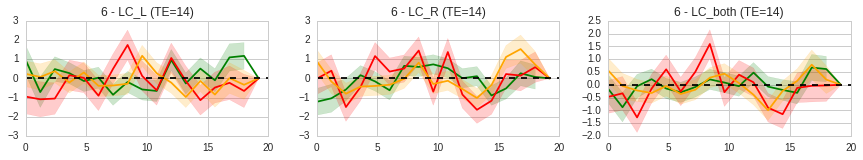

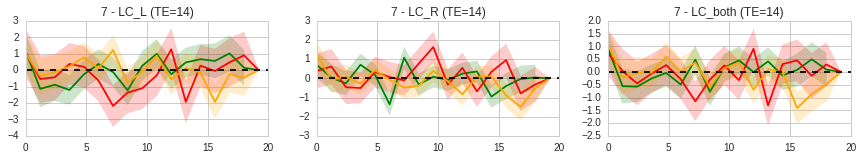

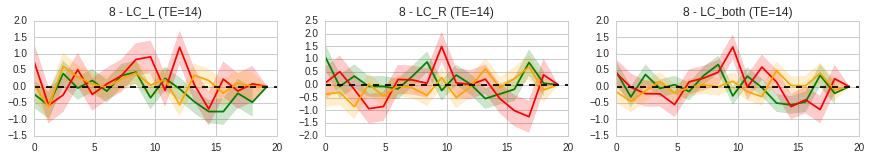

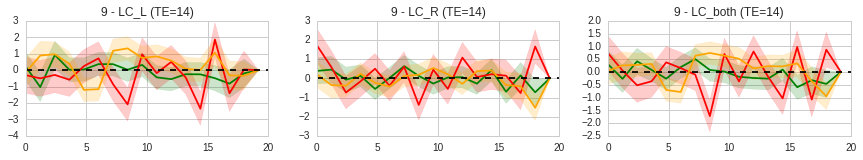

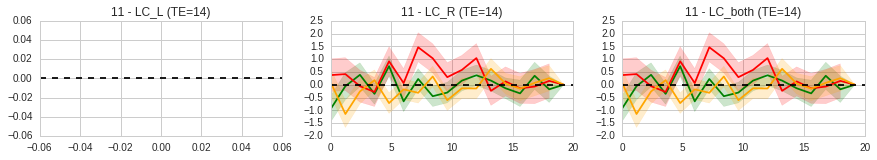

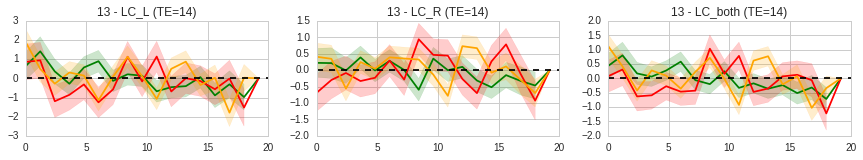

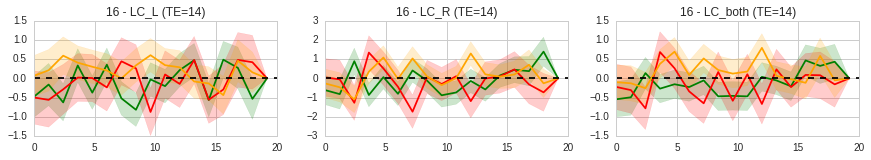

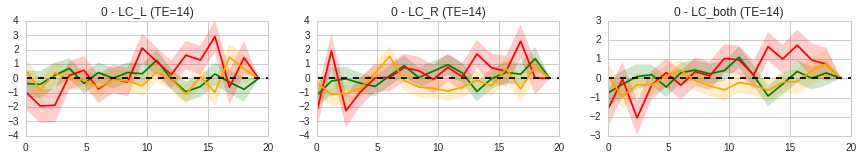

In [14]:
firs = []

for subject_id in df.subject_id.unique():
    plt.figure(figsize=(20, 7))
    for i, mask in enumerate(['LC_L', 'LC_R', 'LC_both']):
        
        try:
            signal = get_signal(subject_id, mask, interpolation='weighted', mask_type='disjunct', phys_filtered=False)
            onsets = get_onsets(subject_id)


            if onsets:
                fir = pyfir.FIR(signal)
                r = fir.fit(onsets, 1.2, resolution = 1.2, len_impulse=20)

                plt.subplot(3, 4, i+1)
                plt.title('%s - %s (TE=14)' % (subject_id, mask))
                r.plot_results({'shock':'red',
                                'cs+':'orange',
                                'cs-':'green',})
                #plt.ylim(-1, 1)

                if i != 7:
                    plt.gca().legend_.remove()

                for condition, hrf in zip(r.conditions, r.beta):
                    for time, value in zip(r.times, hrf):
                        firs.append({'mask':mask,
                                     'subject_id':subject_id,
                                     'condition':condition,
                                     't':time,
                                     'value':value})


        except Exception as e:
            print 'Error with %s/%s - %s' % (subject_id, mask, e)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


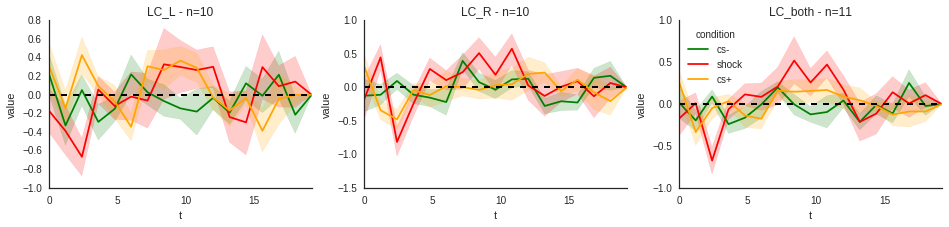

In [15]:
df_firs = pandas.DataFrame(firs)
df_firs = df_firs[~df_firs.value.isnull()]
sns.set_palette(['green', 'red','orange', ])
plt.figure(figsize=(16, 3))

sns.set_style('white')


# for i, ((te, mask), d) in enumerate(df_firs.groupby(['TE', 'mask'], sort=False)):

# yticks = np.arange(-0.3, 0.51, .1).round(1)

for i, mask in enumerate(['LC_L', 'LC_R', 'LC_both']):
    plt.subplot(1, 3, i+1)
#     plt.ylim(-.3, .5)
    sns.tsplot(df_firs[(df_firs['mask'] == mask)], unit='subject_id', time='t', value='value', condition='condition', ci=67)
    
    if i != 2:
        plt.gca().legend_.remove()
        
    plt.title('%s - n=%d' % (mask, df_firs[(df_firs['mask'] == mask)].subject_id.unique().shape[0]))
    plt.axhline(0, lw=2, ls='--', c='k')
    
#     if i < 5:
#         plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))
#         plt.xlabel('')
#     else:
#         plt.xlabel('t (s)')
        
#     if i % 5 == 0:
#         plt.ylabel('% signal change')
        
#         plt.yticks(yticks, yticks)
#     else:
#         plt.yticks(yticks, [''] * len(yticks))
#         plt.ylabel('')
    
# plt.suptitle('Mean signal over all %s subjects' % df_firs.subject_id.unique().shape, fontsize=24)


sns.despine()
plt.savefig('all_nuclei.pdf', transparent=True)

In [16]:
t = df_firs.groupby(['mask', 't', 'condition']).apply(lambda x: sp.stats.ttest_1samp(x.value, 0)[0])
p = df_firs.groupby(['mask', 't', 'condition']).apply(lambda x: sp.stats.ttest_1samp(x.value, 0)[1])


pandas.DataFrame({'t_':t, 'p':p}).reset_index().sort('p')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,mask,t,condition,p,t_
110,LC_both,2.4,shock,0.003555,-3.787976
59,LC_R,2.4,shock,0.006574,-3.514341
8,LC_L,2.4,shock,0.012394,-3.116226
57,LC_R,2.4,cs+,0.013907,-3.044928
70,LC_R,7.2,cs-,0.015833,2.964895
121,LC_both,7.2,cs-,0.017873,2.829327
131,LC_both,10.8,shock,0.019238,2.786397
151,LC_both,19.2,cs-,0.035101,2.435795
80,LC_R,10.8,shock,0.046296,2.309209
85,LC_R,13.2,cs-,0.049656,-2.266386


In [99]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

sns.set_palette('deep')

level2_dict = []
adj_r = []

pars = ['cs+', 'cs-', 'shock']

for subject_id in df.subject_id.unique():


    onsets_dict = get_onsets(subject_id, kind='deconvolve_shock_cs+')
    
    if onsets_dict:
        conditions = []
        onsets = []
        for key in onsets_dict.keys():
            conditions += [key] * len(onsets_dict[key])
            onsets += onsets_dict[key]

        paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                        onset=onsets,
                                                        duration=[[3.]] * len(conditions))
        try:
            signal = get_signal(subject_id, 'LC_L')
            tr = 1.2
            frametimes = np.arange(0, signal.shape[-1] * tr, tr)
            print frametimes.shape
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)
        
        except Exception as e:
            pass

        for i, (mask, d) in enumerate(df_firs.groupby(['mask'])):
            
            try:
                signal = get_signal(subject_id, mask)
                print subject_id, mask, signal.shape, X.shape
                r = sm.GLSAR(signal, X).iterative_fit()


                
                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask})
            except Exception as e:
                print e
                print 'Problem withs %s %s' % (subject_id, mask)
                
            
        plt.suptitle(subject_id, fontsize=24)

(495,)
1 LC_L (495,) (495, 10)
SVD did not converge
Problem withs 1 LC_L
1 LC_R (495,) (495, 10)
SVD did not converge
Problem withs 1 LC_R
1 LC_both (495,) (495, 10)
SVD did not converge
Problem withs 1 LC_both
(495,)
2 LC_L (495,) (495, 10)
2 LC_R (495,) (495, 10)
SVD did not converge
Problem withs 2 LC_R
2 LC_both (495,) (495, 10)
(496,)
3 LC_L (496,) (496, 10)
3 LC_R (496,) (496, 10)
3 LC_both (496,) (496, 10)
(496,)
4 LC_L (496,) (496, 10)
4 LC_R (496,) (496, 10)
4 LC_both (496,) (496, 10)
(495,)
6 LC_L (495,) (495, 10)
6 LC_R (495,) (495, 10)
6 LC_both (495,) (495, 10)
(499,)
7 LC_L (499,) (499, 10)
7 LC_R (499,) (499, 10)
7 LC_both (499,) (499, 10)
(495,)
8 LC_L (495,) (495, 10)
8 LC_R (495,) (495, 10)
8 LC_both (495,) (495, 10)
(499,)
9 LC_L (499,) (499, 10)
9 LC_R (499,) (499, 10)
9 LC_both (499,) (499, 10)
(494,)
11 LC_L (494,) (494, 10)
SVD did not converge
Problem withs 11 LC_L
11 LC_R (494,) (494, 10)
11 LC_both (494,) (494, 10)
(496,)
13 LC_L (496,) (496, 10)
13 LC_R (496,

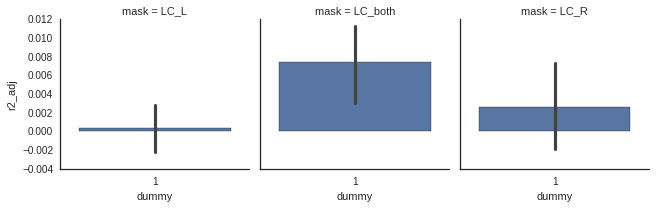

In [100]:
adj_r = pandas.DataFrame(adj_r)
adj_r['dummy'] = 1

f = sns.factorplot(x='dummy', y='r2_adj', data=adj_r, col='mask', col_wrap=4, size=3, units='subject_id',
                   col_order=df_firs['mask'].unique(),
            kind='bar',
                  ci=67)

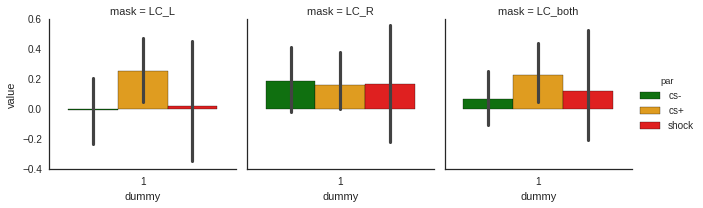

In [101]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1
#sns.set_palette('husl', 4)
f = sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', size=3,
              palette=['green', 'orange', 'red'],
                   col_order=['LC_L', 'LC_R', 'LC_both'],
              hue_order=['cs-', 'cs+', 'shock'],
            kind='bar',
                  ci=95)

In [102]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [113]:
tmp = []

for (mask, condition), d in df_glm.groupby(['mask', 'par']):
    values = d.value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':condition, 'BF':bf[0]})

LC_L cs+
LC_L cs-
LC_L shock
LC_R cs+
LC_R cs-
LC_R shock
LC_both cs+
LC_both cs-
LC_both shock


In [115]:
np.round(pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'].ix[:, ['cs-', 'cs+', 'shock']], 2)

,cs-,cs+,shock
mask,,,
LC_L,0.30,3.52,0.33
LC_R,1.51,1.45,0.59
LC_both,0.55,3.34,0.51


In [117]:
tmp = []

for (mask), d in df_glm.groupby(['mask']):
    values = d[d.par == 'cs+'].value.values - d[d.par == 'cs-'].value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':'cs+ > cs-', 'BF':bf[0]})
    
    
    values = d[d.par == 'shock'].value.values - d[d.par == 'cs+'].value.values
    print mask, condition
    %%R -i d -i values
    %%R library(BayesFactor)
    %%R bf = ttestBF(values, nullInterval=c(0,Inf))
#     %%R print(bf)
    %%R bf = as.vector(bf)
    %%R -o bf
    tmp.append({'mask':mask, 'condition':'shock > cs+', 'BF':bf[0]})

LC_L shock
LC_L shock
LC_R shock
LC_R shock
LC_both shock
LC_both shock


In [118]:
tmp = pandas.DataFrame(tmp)

In [119]:
np.round( pandas.DataFrame(tmp).pivot_table(index='mask', columns=['condition'])['BF'], 2)

,cs+ > cs-,shock > cs+
mask,,
LC_L,1.17,0.19
LC_R,0.27,0.31
LC_both,0.72,0.22


In [109]:
tmp

,BF,condition,mask
0,1.171704,cs+ > cs-,LC_L
1,0.190232,shock > cs+,LC_L
2,0.268592,cs+ > cs-,LC_R
3,0.314137,shock > cs+,LC_R
4,0.720368,cs+ > cs-,LC_both
5,0.224932,shock > cs+,LC_both


# Single trials

In [205]:
onsets

[('cs-.1', [86.072999999999993]),
 ('cs+.1', [102.426]),
 ('cs+.2', [118.28]),
 ('cs-.2', [134.881]),
 ('cs+.3', [150.48599999999999]),
 ('cs+.4', [167.58600000000001]),
 ('cs-.3', [183.44]),
 ('cs+.5', [198.547]),
 ('shock.1', [215.64599999999999]),
 ('cs-.4', [231.99799999999999]),
 ('cs-.5', [249.09800000000001]),
 ('shock.2', [265.20100000000002]),
 ('cs+.6', [281.803]),
 ('cs-.6', [296.89299999999997]),
 ('shock.3', [311.98399999999998]),
 ('cs-.7', [327.12400000000002]),
 ('cs+.7', [344.22300000000001]),
 ('cs+.8', [359.82799999999997]),
 ('cs-.8', [376.18000000000001]),
 ('cs-.9', [391.78500000000003]),
 ('shock.4', [406.87599999999998]),
 ('cs+.9', [421.96600000000001]),
 ('cs-.10', [439.06599999999997]),
 ('cs+.10', [454.92000000000002]),
 ('shock.5', [472.01900000000001]),
 ('cs-.11', [488.62]),
 ('cs+.11', [505.22199999999998]),
 ('cs+.12', [521.57399999999996]),
 ('cs-.12', [537.428]),
 ('shock.6', [553.53099999999995])]

In [38]:
bf.slots.items()

<generator object items at 0x8c837d0>

In [254]:
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

sns.set_palette('deep')

level2_dict = []
adj_r = []

onsets = get_onsets(1, 'single_trial')
pars = onsets.keys()

for subject_id in df.subject_id.unique():


    onsets_dict = get_onsets(subject_id, 'single_trial')
    
    if onsets_dict:
        conditions = []
        onsets = []
        for key in onsets_dict.keys():
            conditions += [key] * len(onsets_dict[key])
            onsets += onsets_dict[key]

        paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                        onset=onsets,
                                                        duration=[[3.]] * len(conditions))
        try:
            signal = get_signal(subject_id, 'LC_L')
            tr = 1.2
            frametimes = np.arange(0, signal.shape[-1] * tr, tr)
            print frametimes.shape
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)
        
        except Exception as e:
            pass

        for i, (mask, d) in enumerate(df_firs.groupby(['mask'])):
            
            try:
                signal = get_signal(subject_id, mask)
                print subject_id, mask, signal.shape, X.shape
                r = sm.GLSAR(signal, X).iterative_fit()


                
                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask})
            except Exception as e:
                print e
                print 'Problem withs %s %s' % (subject_id, mask)
                
            
        plt.suptitle(subject_id, fontsize=24)

(495,)
1 LC_L (495,) (495, 40)
On entry to DLASCL parameter number 4 had an illegal value
Problem withs 1 LC_L
1 LC_R (495,) (495, 40)
On entry to DLASCL parameter number 4 had an illegal value
Problem withs 1 LC_R
1 LC_both (495,) (495, 40)
On entry to DLASCL parameter number 4 had an illegal value
Problem withs 1 LC_both
(495,)
2 LC_L (495,) (495, 40)
2 LC_R (495,) (495, 40)
On entry to DLASCL parameter number 4 had an illegal value
Problem withs 2 LC_R
2 LC_both (495,) (495, 40)
(496,)
3 LC_L (496,) (496, 40)
3 LC_R (496,) (496, 40)
3 LC_both (496,) (496, 40)
(496,)
4 LC_L (496,) (496, 40)
4 LC_R (496,) (496, 40)
4 LC_both (496,) (496, 40)
(495,)
6 LC_L (495,) (495, 40)
6 LC_R (495,) (495, 40)
6 LC_both (495,) (495, 40)
(499,)
7 LC_L (499,) (499, 40)
7 LC_R (499,) (499, 40)
7 LC_both (499,) (499, 40)
(495,)
8 LC_L (495,) (495, 40)
8 LC_R (495,) (495, 40)
8 LC_both (495,) (495, 40)
(499,)
9 LC_L (499,) (499, 40)
9 LC_R (499,) (499, 40)
9 LC_both (499,) (499, 40)
(494,)
11 LC_L (494,)

In [260]:
single_trials = pandas.DataFrame(level2_dict)
single_trials['t'] = single_trials.par.map(lambda x: x.split('.')[1]).astype(int)
single_trials['condition'] = single_trials.par.map(lambda x: x.split('.')[0])

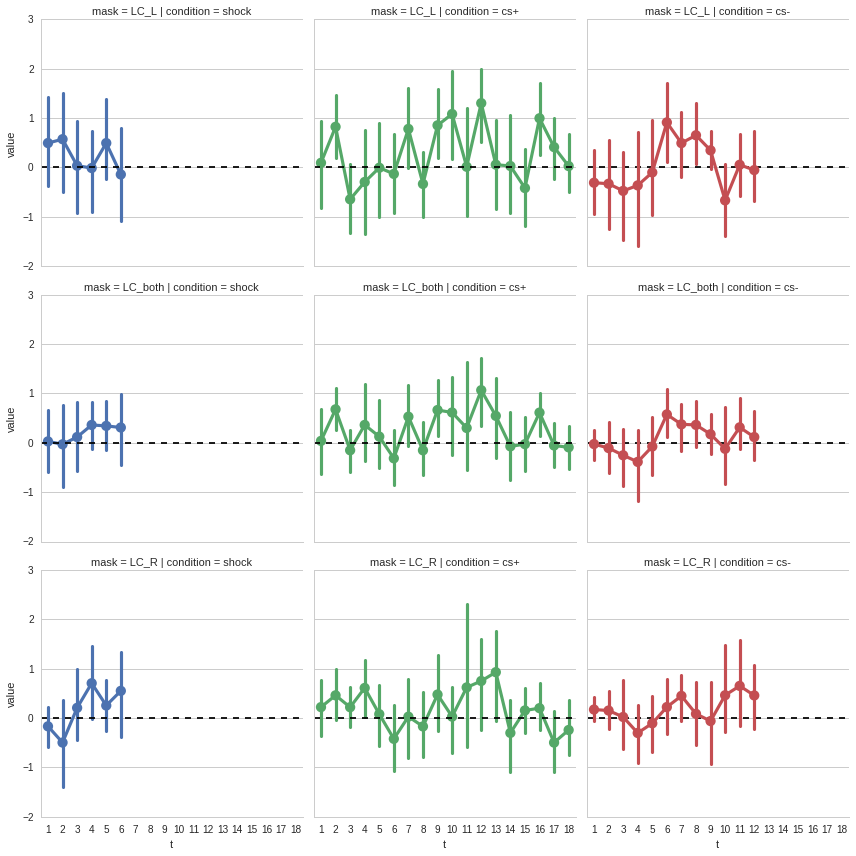

In [261]:
fac = sns.factorplot('t', 'value', 'condition', single_trials, row='mask', col='condition', ci=95, x_order=np.arange(1, 19))

for ax in fac.axes.flatten():
    ax.axhline(0, c='k', ls='--')

ValueError: cannot label index with a null key

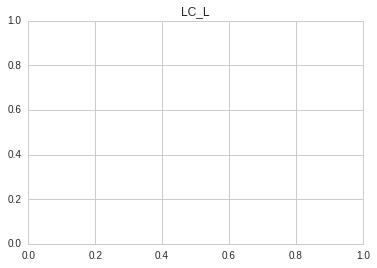

In [220]:

for mask, d in single_trials.groupby('mask'):
    plt.figure()
    plt.title(mask)
    sns.tsplot(d, t='t', condition='condition', value='value', unit='subject_id')